##### This requires that the Nontarget and KO files have identical line entries (i.e., each has PP_#### for KO and Nontarget)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from adjustText import adjust_text
import os

# Load the data files
# target_data = pd.read_csv('250228_Jan_Abundance_T.csv')
# nontarget_data = pd.read_csv('250228_Jan_Abundance_NT.csv')

nontarget_data = pd.read_csv('241217_nontargets.csv')
target_data = pd.read_csv('241217_targets.csv')

# nontarget_data = pd.read_csv('PP_0812_15_NonTar.csv')
# target_data = pd.read_csv('PP_0812_15_Tar.csv')
name_df = pd.read_csv('proteomics_id_translator_240305.csv')

In [2]:
translator_dict = {}
nontranslated = 0
for orig_label in nontarget_data['Protein.Group']:
    matching_idx = name_df['original'].str.contains(orig_label, regex=False)
    if sum(matching_idx) == 1:
        translator_dict[orig_label] = name_df.loc[matching_idx, 'locus'].values[0]
    else:
        translator_dict[orig_label] = orig_label  # Keep the original name if no match
        nontranslated += 1
print(f"In total, N = {nontranslated}/{len(nontarget_data['Protein.Group'])} proteins were not translated to locus names")

# Apply the translation to both files
nontarget_data['Protein.Group'] = nontarget_data['Protein.Group'].map(translator_dict)
target_data['Protein.Group'] = target_data['Protein.Group'].map(translator_dict)

In total, N = 2880/76032 proteins were not translated to locus names


In [3]:
specific_proteins = [
    'PP_0977',
    'PP_2680',
    'PP_2791',
    'PP_2792',
    'PP_2793',
    'PP_2794',
    'PP_2208',
    'PP_2209',
    'PP_0378',
    'PP_0379',
    'PP_0977',
    'PP_1018',
    'PP_2664',
    'PP_2665',
    'PP_3379',
    'PP_3416',
    'PP_0986',
    'PP_1593',
    'PP_1638',
    'PP_5313',
    'PP_1982']

In [7]:
# Create the directory
output_dir = 'Figure_Export'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Define thresholds for filtering
fold_change_threshold = 2
log2_FC_threshold= np.log2(fold_change_threshold)

p_value_threshold = 0.05
log10_pval_threshold = -np.log10(p_value_threshold)
target_filter = 10000
nontarget_filter = 10000

Log2 and Log10 values saved to 'Volcano_Results.csv'


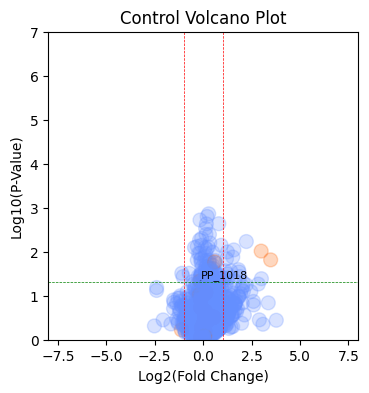

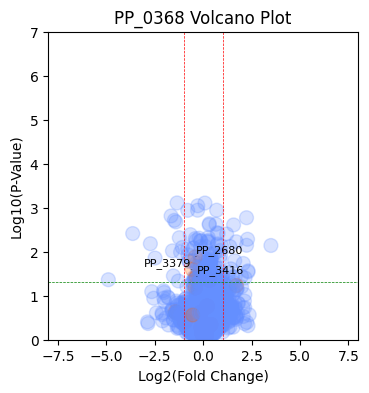

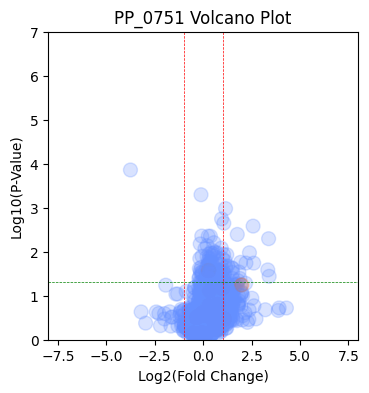

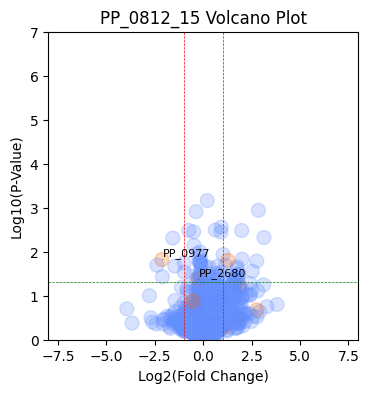

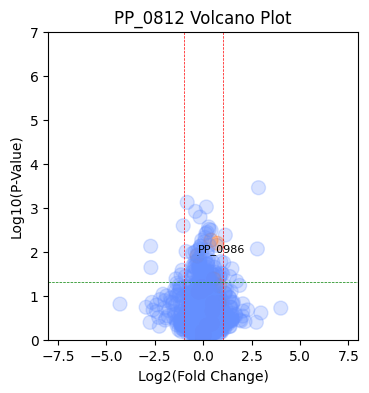

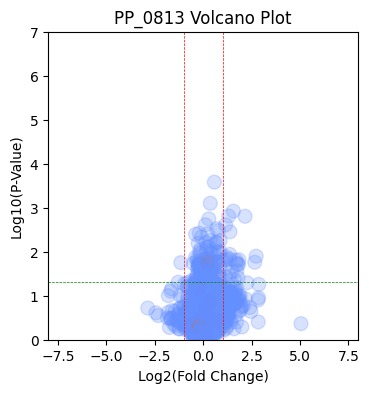

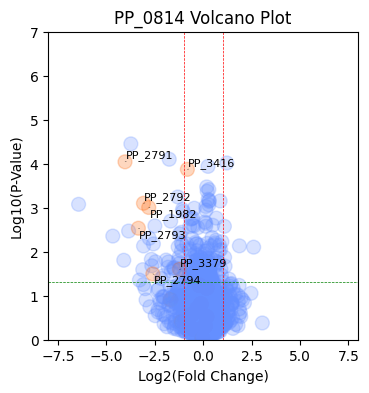

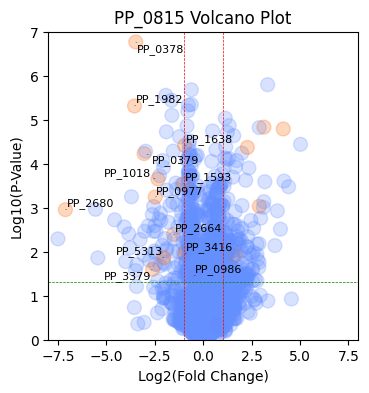

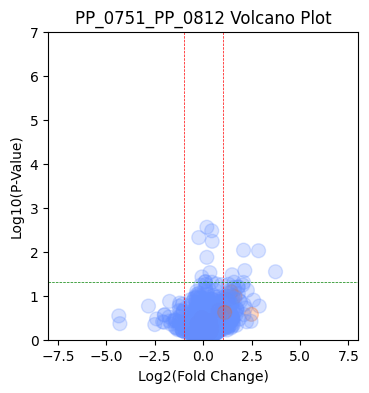

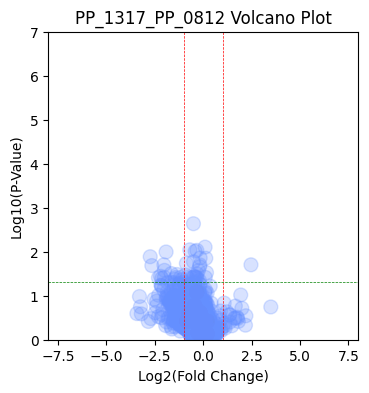

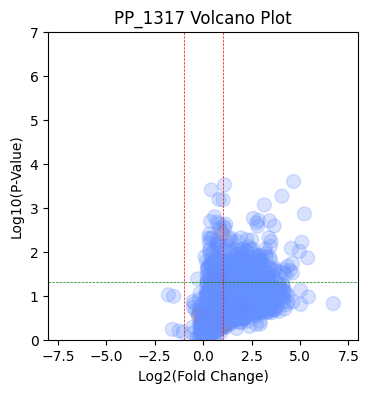

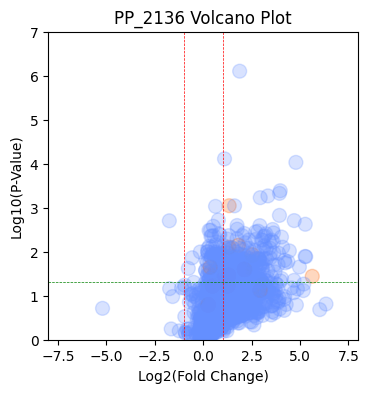

In [10]:
log2_log10_results = pd.DataFrame()
sample_names = nontarget_data['Sample'].unique()

for sample in sample_names:
    # Filter data for the current sample
    target_sample_data = target_data[target_data['Sample'] == sample]
    nontarget_sample_data = nontarget_data[nontarget_data['Sample'] == sample]
    
    # Compute mean %_of_protein_abundance_Top3-method for each protein
    target_mean = target_sample_data.groupby('Protein.Group')['Counts_sum'].mean().reset_index()
    nontarget_mean = nontarget_sample_data.groupby('Protein.Group')['Counts_sum'].mean().reset_index()

    # Rename columns for clarity
    target_mean.rename(columns={'Counts_sum': 'target_mean'}, inplace=True)
    nontarget_mean.rename(columns={'Counts_sum': 'nontarget_mean'}, inplace=True)

    # Filter target_mean to include only abundances > abund_filter
    target_mean = target_mean[target_mean['target_mean'] > target_filter]
    nontarget_mean = nontarget_mean[nontarget_mean['nontarget_mean'] > nontarget_filter]

    # Merge the data on Protein.Group
    merged_data = pd.merge(target_mean, nontarget_mean, on='Protein.Group', how='outer')

    # Calculate log2 fold change (fill missing values with NaN)
    merged_data['log2_change'] = np.log2(merged_data['target_mean'] / merged_data['nontarget_mean'])

    # Debug: Check if log2_change contains NaN values
    if merged_data['log2_change'].isna().all():
        print(f"All log2 fold changes are NaN for {sample}")
        continue

    # Compute p-values (assume replicates data exists for actual p-value calculation)
    target_reps = target_sample_data[['Protein.Group', 'Counts_sum']]
    nontarget_reps = nontarget_sample_data[['Protein.Group', 'Counts_sum']]

    p_values = []
    for protein in merged_data['Protein.Group']:
        group1 = target_reps[target_reps['Protein.Group'] == protein]['Counts_sum']
        group2 = nontarget_reps[nontarget_reps['Protein.Group'] == protein]['Counts_sum']
        if not group1.empty and not group2.empty:
            _, p_val = ttest_ind(group1, group2, equal_var=False)
        else:
            p_val = np.nan
        p_values.append(p_val)

    # Add p-values and log10 transformation
    merged_data['p_value'] = p_values
    merged_data['log10_p_value'] = -np.log10(merged_data['p_value'])

    # Debug: Check if log10_p_value contains NaN values
    if merged_data['log10_p_value'].isna().all():
        print(f"All log10 p-values are NaN for {sample}")
        continue

    # Filter based on plotting criteria
    filtered_data = merged_data[
        (merged_data['log2_change'].abs() > log2_FC_threshold) &
        (merged_data['log10_p_value'] > -np.log10(p_value_threshold))
    ]

    # Store filtered results in log2_log10_results
    if not filtered_data.empty:
        temp_results = filtered_data[['Protein.Group', 'log2_change', 'log10_p_value']].copy()
        temp_results.rename(
            columns={'log2_change': f'{sample}_log2_FC', 'log10_p_value': f'{sample}_log10_pval'},
            inplace=True
        )

        # Merge with the main results DataFrame
        if log2_log10_results.empty:
            log2_log10_results = temp_results
        else:
            log2_log10_results = pd.merge(
                log2_log10_results,
                temp_results,
                on='Protein.Group',
                how='outer'
            )

    # Create volcano plot for the current sample
    fold_change = merged_data['log2_change']
    p_values = merged_data['log10_p_value']

    # Create a color list for the scatter plot
    colors = ['#FE6100' if protein in specific_proteins else '#648FFF' for protein in merged_data['Protein.Group']]

    plt.figure(figsize=(4, 4))
    plt.scatter(fold_change, p_values, s=100, alpha=0.25, c=colors)
    plt.title(f"{sample} Volcano Plot")
    plt.xlabel("Log2(Fold Change)")
    plt.ylabel("Log10(P-Value)")
    plt.grid(False)
    plt.ylim(0, 7)
    plt.xlim(-8, 8)
    # Threshold lines
    plt.axvline(x=log2_FC_threshold, color='r', linestyle='--', linewidth=0.5)
    plt.axvline(x=-log2_FC_threshold, color='r', linestyle='--', linewidth=0.5)
    plt.axhline(y=log10_pval_threshold, color='g', linestyle='--', linewidth=0.5)

    # Annotate significant points
    texts = []
#     labels = merged_data['Protein.Group']
#     for i, label in enumerate(labels):
#         if (fold_change[i] > log2_FC_threshold or fold_change[i] < -log2_FC_threshold) and p_values[i] > log10_pval_threshold:
#             if label in specific_proteins:
#                 text = plt.text(fold_change[i], p_values[i], label, fontsize=6)
#                 texts.append(text)

#     if texts:
#         adjust_text(texts, arrowprops=dict(arrowstyle='-', color='red', lw=0.25))

    labels = merged_data['Protein.Group']
    for i, label in enumerate(labels):
        if fold_change[i] < 0 and p_values[i] > log10_pval_threshold:
            if label in specific_proteins:
                text = plt.text(fold_change[i], p_values[i], label, fontsize=8)
                texts.append(text)

    if texts:
        adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black', lw=0.25))

    # Save the figure
    plt.savefig(os.path.join(output_dir, f'{sample}_volcano_plot_arrows.pdf'))

# Save the filtered log2 and log10 values to a CSV file
if not log2_log10_results.empty:
    log2_log10_results.to_csv('Volcano_Results.csv', index=False)
    print("Log2 and Log10 values saved to 'Volcano_Results.csv'")
else:
    print("No significant results to save.")

In [6]:
log2_log10_results = pd.DataFrame()
sample_names = nontarget_data['Sample'].unique()

for sample in sample_names:
    # Filter data for the current sample
    target_sample_data = target_data[target_data['Sample'] == sample]
    nontarget_sample_data = nontarget_data[nontarget_data['Sample'] == sample]
    
    # Compute mean %_of_protein_abundance_Top3-method for each protein
    target_mean = target_sample_data.groupby('Protein.Group')['Counts_sum'].mean().reset_index()
    nontarget_mean = nontarget_sample_data.groupby('Protein.Group')['Counts_sum'].mean().reset_index()

    # Rename columns for clarity
    target_mean.rename(columns={'Counts_sum': 'target_mean'}, inplace=True)
    nontarget_mean.rename(columns={'Counts_sum': 'nontarget_mean'}, inplace=True)

    # Filter target_mean to include only abundances > abund_filter
    # target_mean = target_mean[target_mean['target_mean'] > abund_filter]
    nontarget_mean = nontarget_mean[nontarget_mean['nontarget_mean'] > abund_filter]

    # Merge the data on Protein.Group
    merged_data = pd.merge(target_mean, nontarget_mean, on='Protein.Group', how='outer')

    # Calculate log2 fold change (fill missing values with NaN)
    merged_data['log2_change'] = np.log2(merged_data['target_mean'] / merged_data['nontarget_mean'])

    # Debug: Check if log2_change contains NaN values
    if merged_data['log2_change'].isna().all():
        print(f"All log2 fold changes are NaN for {sample}")
        continue

    # Compute p-values (assume replicates data exists for actual p-value calculation)
    target_reps = target_sample_data[['Protein.Group', 'Counts_sum']]
    nontarget_reps = nontarget_sample_data[['Protein.Group', 'Counts_sum']]

    p_values = []
    for protein in merged_data['Protein.Group']:
        group1 = target_reps[target_reps['Protein.Group'] == protein]['Counts_sum']
        group2 = nontarget_reps[nontarget_reps['Protein.Group'] == protein]['Counts_sum']
        if not group1.empty and not group2.empty:
            _, p_val = ttest_ind(group1, group2, equal_var=False)
        else:
            p_val = np.nan
        p_values.append(p_val)

    # Add p-values and log10 transformation
    merged_data['p_value'] = p_values
    merged_data['log10_p_value'] = -np.log10(merged_data['p_value'])

    # Debug: Check if log10_p_value contains NaN values
    if merged_data['log10_p_value'].isna().all():
        print(f"All log10 p-values are NaN for {sample}")
        continue

    # Filter based on plotting criteria
    filtered_data = merged_data[
        (merged_data['log2_change'].abs() > log2_FC_threshold) &
        (merged_data['log10_p_value'] > -np.log10(p_value_threshold))
    ]

    # Store filtered results in log2_log10_results
    if not filtered_data.empty:
        temp_results = filtered_data[['Protein.Group', 'log2_change', 'log10_p_value']].copy()
        temp_results.rename(
            columns={'log2_change': f'{sample}_log2_FC', 'log10_p_value': f'{sample}_log10_pval'},
            inplace=True
        )

        # Merge with the main results DataFrame
        if log2_log10_results.empty:
            log2_log10_results = temp_results
        else:
            log2_log10_results = pd.merge(
                log2_log10_results,
                temp_results,
                on='Protein.Group',
                how='outer'
            )

    # Create volcano plot for the current sample
    fold_change = merged_data['log2_change']
    p_values = merged_data['log10_p_value']

    # Create a color list for the scatter plot
    colors = ['#FE6100' if protein in specific_proteins else '#648FFF' for protein in merged_data['Protein.Group']]

    plt.figure(figsize=(4, 4))
    plt.scatter(fold_change, p_values, s=40, alpha=0.25, c=colors)
    plt.title(f"{sample} Volcano Plot")
    plt.xlabel("Log2(Fold Change)")
    plt.ylabel("Log10(P-Value)")
    plt.grid(False)
    plt.ylim(0, 7)
    plt.xlim(-8, 8)

    # Threshold lines
    plt.axvline(x=log2_FC_threshold, color='r', linestyle='--', linewidth=1)
    plt.axvline(x=-log2_FC_threshold, color='r', linestyle='--', linewidth=1)
    plt.axhline(y=log10_pval_threshold, color='g', linestyle='--', linewidth=1)

    # Annotate significant points
    texts = []
    labels = merged_data['Protein.Group']
    for i, label in enumerate(labels):
        if (fold_change[i] > log2_FC_threshold or fold_change[i] < -log2_FC_threshold) and p_values[i] > log10_pval_threshold:
            if label in specific_proteins:
                text = plt.text(fold_change[i], p_values[i], label, fontsize=6)
                texts.append(text)

    if texts:
        adjust_text(texts, arrowprops=dict(arrowstyle='-', color='red', lw=0.25))

    # Save the figure
    plt.savefig(os.path.join(output_dir, f'{sample}_volcano_plot_arrows.pdf'))

# Save the filtered log2 and log10 values to a CSV file
if not log2_log10_results.empty:
    log2_log10_results.to_csv('Volcano_Results.csv', index=False)
    print("Log2 and Log10 values saved to 'Volcano_Results.csv'")
else:
    print("No significant results to save.")

NameError: name 'abund_filter' is not defined